<a href="https://colab.research.google.com/github/zeynepnaztuna/PCS_CS_Project_Zeynep/blob/main/PCS_CS_Project_Zeynep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preliminaries:**

In [1]:

!pip install tensorflow==2.12.*

In [2]:
!pip install biopython # Install the biopython library which contains the SeqIO module.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.9 MB/s eta 0:00:00


In some cases in spite of importing a whole library we import a subpart of it in order to save memory and improve perfomance


In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy import stats

from Bio import SeqIO  # to manipulate fasta like files

from sklearn.decomposition import PCA # for dimensional reduction and visualization
from sklearn.cluster import KMeans # for K-means clustering algorithm
from sklearn.linear_model import LogisticRegression # for building a logicstic regression classifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # for building the confusion matrix


# Later For Task 5:

import tensorflow as tf  # for the VAE implementation
from tensorflow.keras import layers, Model, backend as K  # for model building
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set plot style for a cleaner visual appearance
plt.style.use('seaborn-v0_8-darkgrid')

Opening the data set:

In [4]:
!git clone https://github.com/zeynepnaztuna/PCS_CS_Project_Zeynep.git

%cd PCS_CS_Project_Zeynep

file_path1 = "MSA_nat_with_annotation.faa"  # Replace with the exact file name if different
nat_sequences = list(SeqIO.parse(file_path1, "fasta"))

file_path2 = "MSA_art.faa"  # Replace with the exact file name if different
art_sequences = list(SeqIO.parse(file_path2, "fasta"))

Cloning into 'PCS_CS_Project_Zeynep'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 91.23 KiB | 5.70 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/PCS_CS_Project_Zeynep


A test print out:

In [5]:
print("----- An example of a natural sequence -----")
print("")
print(nat_sequences[0])
print("")
print("Number of entries in one sequence: ")
print(np.shape(nat_sequences[0].seq)[0])


----- An example of a natural sequence -----

ID: sequence_1
Name: sequence_1
Description: sequence_1 functional_true
Number of features: 0
Seq('-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERD...QQH')

Number of entries in one sequence: 
96


# **Task 1:**

**`One hot encoding`**

We are going to define a function that uses the given **representation** for one-hot encoding of the protein sequences to transform a sequence of amino acids to **vectors** containing one entry equal to 1, and all the other equal to 0.

In [6]:
# Function to one-hot encode a single amino acid
def one_hot_encode_aa(aa):

    aa_index = 'ACDEFGHIKLMNPQRSTVWY-'.find(aa)

    if aa_index == -1:  # In case an unknown character is found
        raise ValueError(f"Unrecognized amino acid: {aa}")  # Raise an error for unknown amino acids

    elif aa == '-':
        return np.zeros(20, dtype=int)

    else:
        one_hot = np.zeros(20, dtype=int)
        one_hot[aa_index] = 1
        return one_hot

# One-hot encode entire sequences
def encode_sequences(sequences):

    encoded_data = []
    for seq_record in sequences:
        encoded_seq = np.array([one_hot_encode_aa(aa) for aa in seq_record.seq])
        encoded_data.append(encoded_seq)

    return np.array(encoded_data)

# Apply one-hot encoding to the loaded sequences
nat_encoded_sequences = encode_sequences(nat_sequences)
art_encoded_sequences = encode_sequences(art_sequences)

A test print out:

In [7]:
# Output the shape and first part of the encoded data for the first sequence
print("Encoded first sequence shape:", nat_encoded_sequences[1].shape)
print("Encoded first sequence data:\n", nat_encoded_sequences[1][:6])  # Shows the first 5 encoded amino acids


Encoded first sequence shape: (96, 20)
Encoded first sequence data:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


# **Task 2:**

**Principal Compartment Analysis (PCA)**

We are going to determine the first few principle components (PCs) of the dataset and project sequences onto these PCs.

**PCA of the Natural Data**

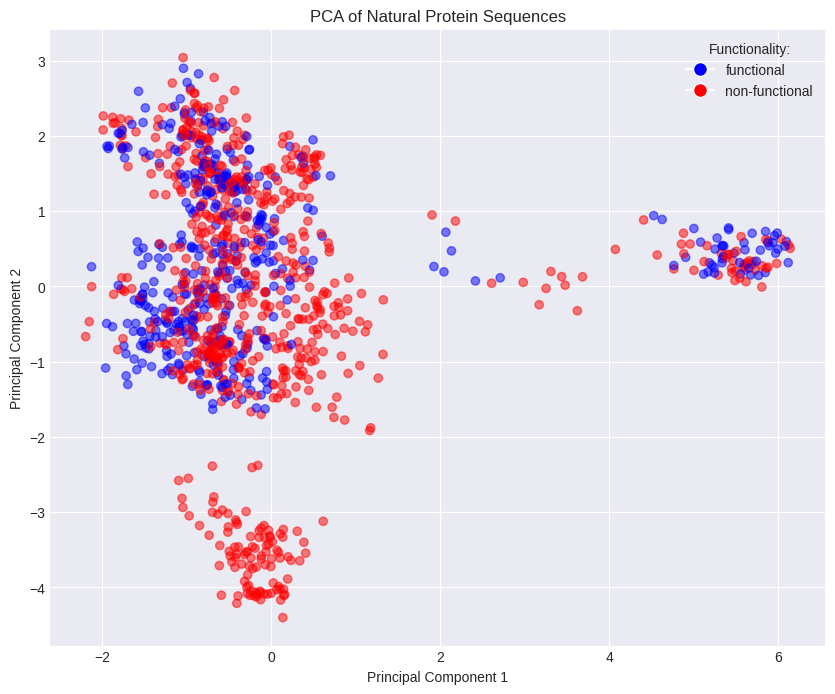

In [8]:

pca = PCA(n_components=2)  # Using 2 components for 2D visualization

# Reshape 3D array to a 2D array
reshaped_nat_encoded_sequences = nat_encoded_sequences.reshape(len(nat_encoded_sequences), 96 * 20)

# Fit PCA model to the natural sequences
pca.fit(reshaped_nat_encoded_sequences)

# Find the PCA's of natural data
principal_components_natural = pca.transform(nat_encoded_sequences.reshape(len(nat_encoded_sequences), 96 * 20))

# Extract functionality information
nat_functionality = [seq.description.split()[-1] for seq in nat_sequences]

# Color map for functionality
color_map = {'functional_true': 'blue', 'functional_false': 'red'}
colors = [color_map[func] for func in nat_functionality]


# Plot natural sequences
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    principal_components_natural[:, 0],
    principal_components_natural[:, 1],
    c=colors,
    alpha=0.5
)

# Add legend for functionality
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='functional'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='non-functional')
]
plt.legend(handles=legend_elements, title="Functionality:", loc='best')

# Title and labels
plt.title('PCA of Natural Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


**PCA of Both Natural and Artificial Data**

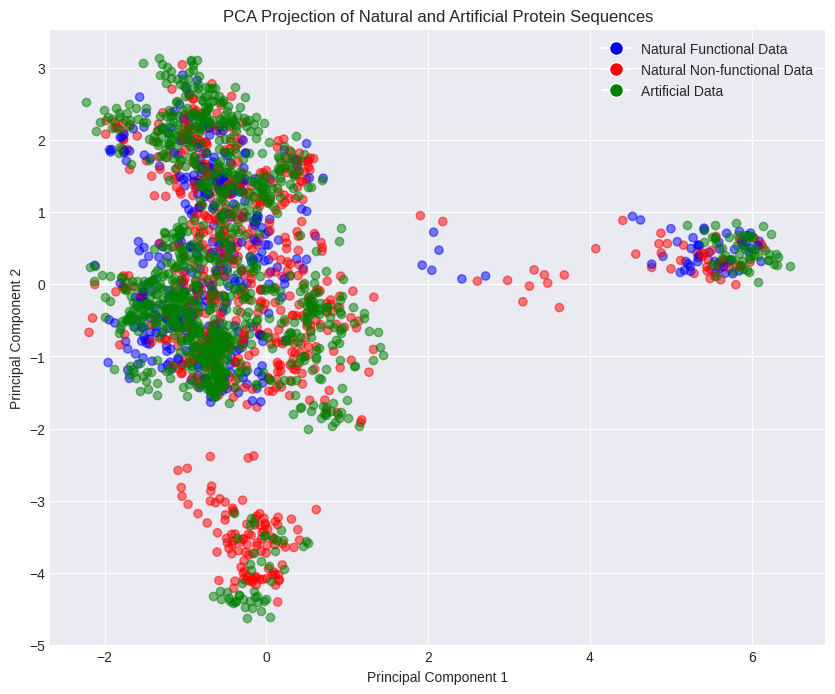

In [9]:
# Reshape 3D array to a 2D array
reshaped_art_encoded_sequences = art_encoded_sequences.reshape(len(art_encoded_sequences), 96 * 20)

# Find the PCA's of artificial data for the PCA model fitted earlier for the natural data
principal_components_artificial = pca.transform(reshaped_art_encoded_sequences)


# Plot both natural and artificial sequences in the same PCA plot
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(
    principal_components_natural[:, 0],
    principal_components_natural[:, 1],
    c=colors,
    alpha=0.5,
    label='Natural'
)

# Artificial sequences
plt.scatter(
    principal_components_artificial[:, 0],
    principal_components_artificial[:, 1],
    color='green',
    alpha=0.5,
    label='Artificial'
)

# Add legend for functionality and data source
legend_elements = [
    # Functionality legends
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Natural Functional Data'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Natural Non-functional Data'),
    # Data source legends
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Artificial Data')
]
plt.legend(handles=legend_elements, loc='best')

# Add title and labels
plt.title('PCA Projection of Natural and Artificial Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

We can clearly see that the artifically generated sequences that was given to us **occupy a similar region in (dimensionally reduced) sequence space**. This shows us that the generative produce is succesful.

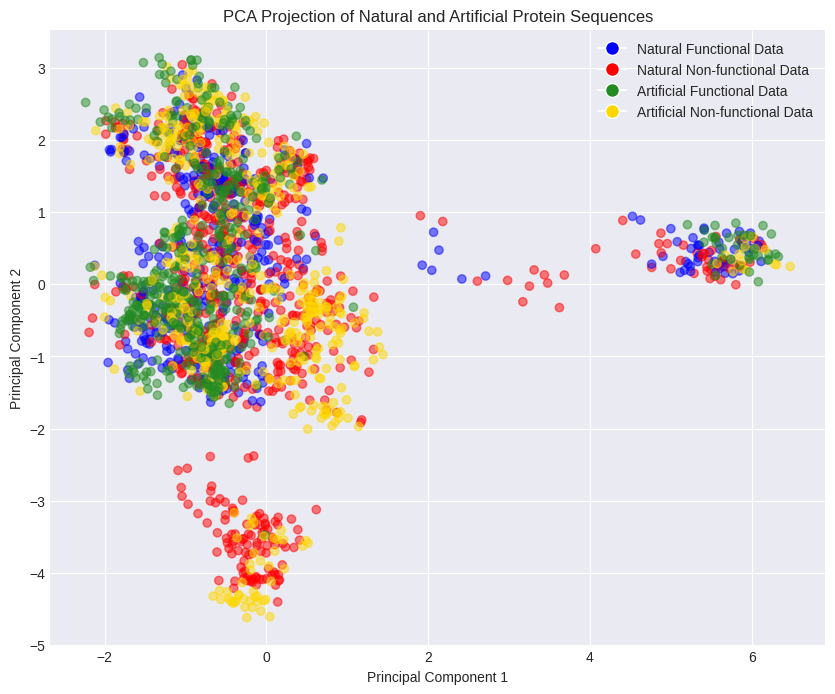

In [11]:
# Extract functionality information of artifical data
art_functionality = [seq.description.split()[-1] for seq in art_sequences]

# Color map for functionality
color_map_art = {'functional_true': 'forestgreen', 'functional_false': 'gold'}
colors_art = [color_map_art[func] for func in art_functionality]

# Plot both natural and artificial sequences in the same PCA plot
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(
    principal_components_natural[:, 0],
    principal_components_natural[:, 1],
    c=colors,
    alpha=0.5,
    label='Natural'
)

# Artificial sequences
plt.scatter(
    principal_components_artificial[:, 0],
    principal_components_artificial[:, 1],
    color=colors_art,
    alpha=0.5,
    label='Artificial'
)

# Add legend for functionality and data source
legend_elements = [
    # Functionality legends
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Natural Functional Data'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Natural Non-functional Data'),
    # Data source legends
    Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=10, label='Artificial Functional Data'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10, label='Artificial Non-functional Data')
]
plt.legend(handles=legend_elements, loc='best')

# Add title and labels
plt.title('PCA Projection of Natural and Artificial Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


We can see that the functionality of the artifical data is in accordance with the space it occupies in the dimensionally reduced sequence space. This again shows us that the generative produce is succesful and the functionality information of the data makes sense.

# **Task 3:**

**K-Means Clustering** with different cluster numbers:

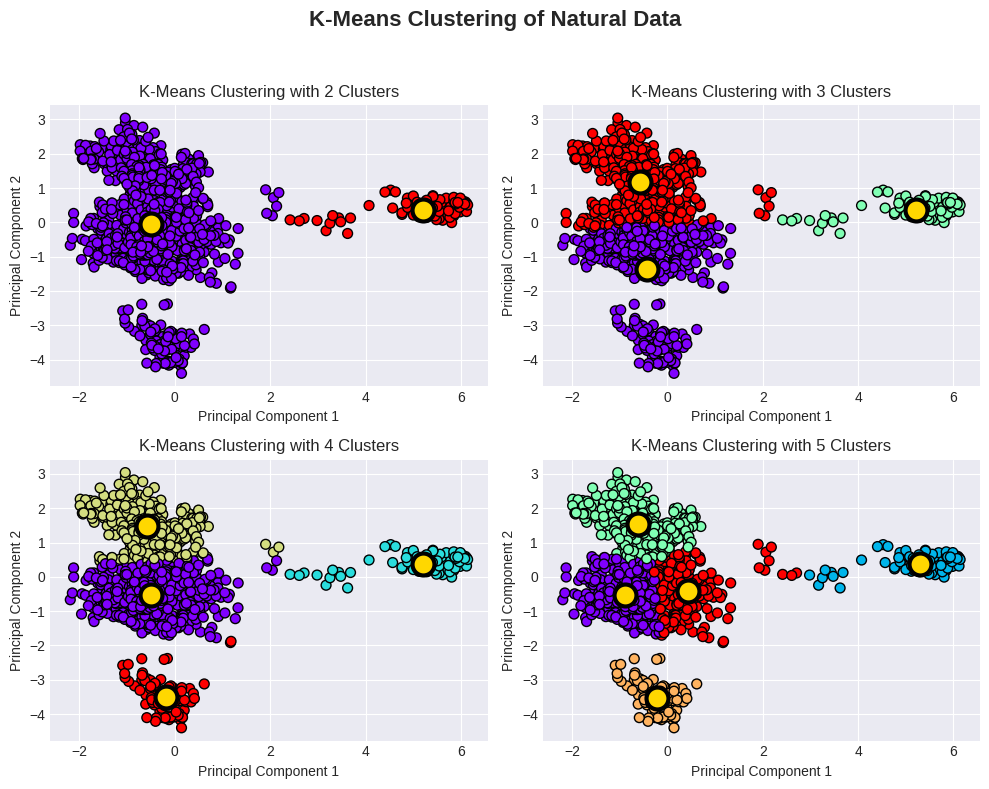

In [12]:
# Prepare the figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Define the number of clusters for each subplot
cluster_counts = [2, 3, 4, 5]

# Loop through the cluster counts and plot each
for ax, k in zip(axes.flat, cluster_counts):
    # Initialize KMeans with k clusters
    est = KMeans(k, random_state=42)

    # Fit the model to the data
    est.fit(principal_components_natural)

    # Predict the cluster labels for the data points
    y_kmeans = est.predict(principal_components_natural)

    # Plot the clustered data points
    scatter = ax.scatter(
        principal_components_natural[:, 0],
        principal_components_natural[:, 1],
        c=y_kmeans,
        s=50,
        cmap='rainbow',
        edgecolor='black',
        linewidth=1
    )

    # Mark the cluster centers
    ax.scatter(
        est.cluster_centers_[:, 0],
        est.cluster_centers_[:, 1],
        s=250,
        color="gold",
        edgecolor='black',
        linewidth=3
    )

    # Add title for each subplot
    ax.set_title(f'K-Means Clustering with {k} Clusters')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.grid(True)


# Add a big title to the entire figure
fig.suptitle('K-Means Clustering of Natural Data', fontsize=16, fontweight='bold')

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the big title

# Show the plot
plt.show()

We can observe that the best fit for this data is when take 4 as the cluster number. Hence, we proceed with the 4-clustered model.

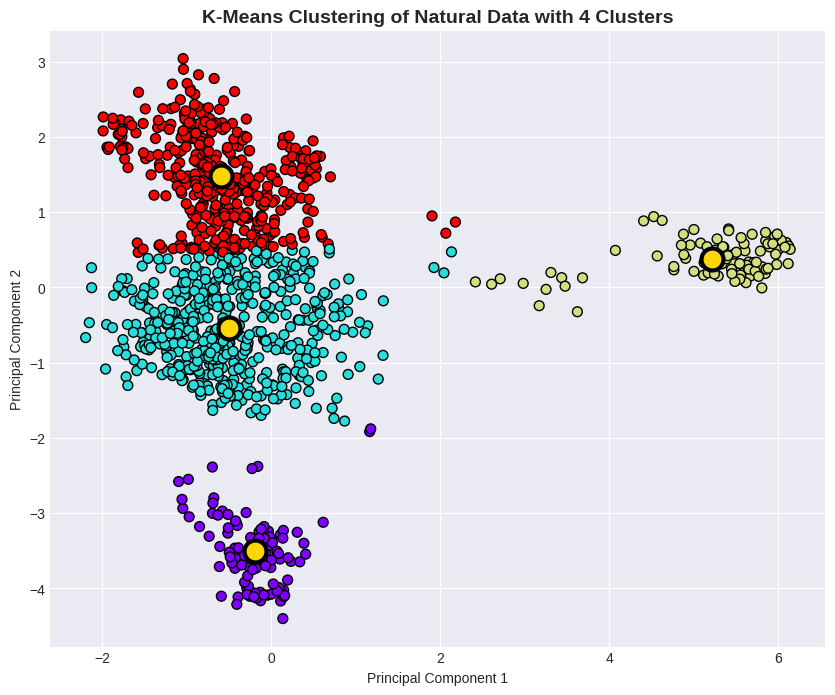

In [13]:

# Initialize KMeans with 4 clusters
est = KMeans(4)

# Fit the model to the data
est.fit(principal_components_natural)

# Predict the cluster labels for the data points
y_kmeans = est.predict(principal_components_natural)

# Plot the clustered data points with color coding for clusters
plt.figure(figsize=(10, 8))
plt.scatter(principal_components_natural[:, 0], principal_components_natural[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.title('K-Means Clustering of Natural Data with 4 Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

**Question 1:** Are functional and non-functional sequences separated into distinct clusters in natural data?
**No**


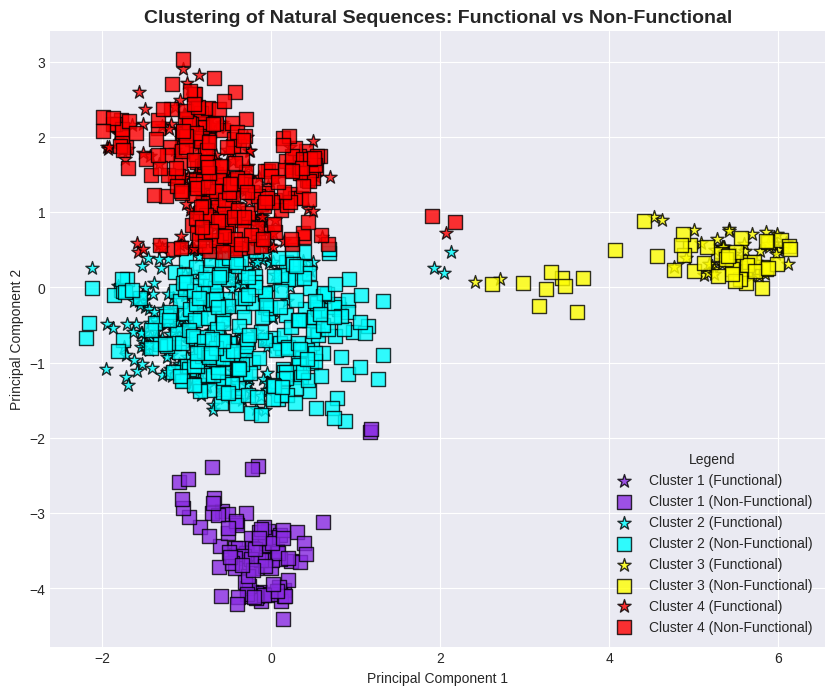

In [14]:
plt.figure(figsize=(10, 8))

# Define markers and cluster colors
markers = {'functional_true': '*', 'functional_false': 's'}
cluster_colors = ['blueviolet', 'cyan', 'yellow', 'red']  # Customize as needed
functionality_labels = {'functional_true': 'Functional', 'functional_false': 'Non-Functional'}

# Plot each combination of functionality and cluster
for cluster in range(4):  # Loop over clusters
    for func, marker in markers.items():  # Loop over functionality
        indices = [
            i for i, (label, func_type) in enumerate(zip(y_kmeans, nat_functionality))
            if label == cluster and func_type == func
        ]
        plt.scatter(
            principal_components_natural[indices, 0],
            principal_components_natural[indices, 1],
            c=cluster_colors[cluster],  # Color based on the cluster
            marker=marker,  # Marker based on functionality
            edgecolor='black',  # Add an outline to the markers
            linewidth=1,
            s=100,  # Size for clear visibility
            label=f"Cluster {cluster+1} ({functionality_labels[func]})",
            alpha=0.8
        )

# Add legend with unique entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
plt.legend(by_label.values(), by_label.keys(), title="Legend", loc='best', fontsize=10)

# Add title and axis labels
plt.title('Clustering of Natural Sequences: Functional vs Non-Functional', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


**Question 2:** Did the clustering changed after including the artificial data?
**No**

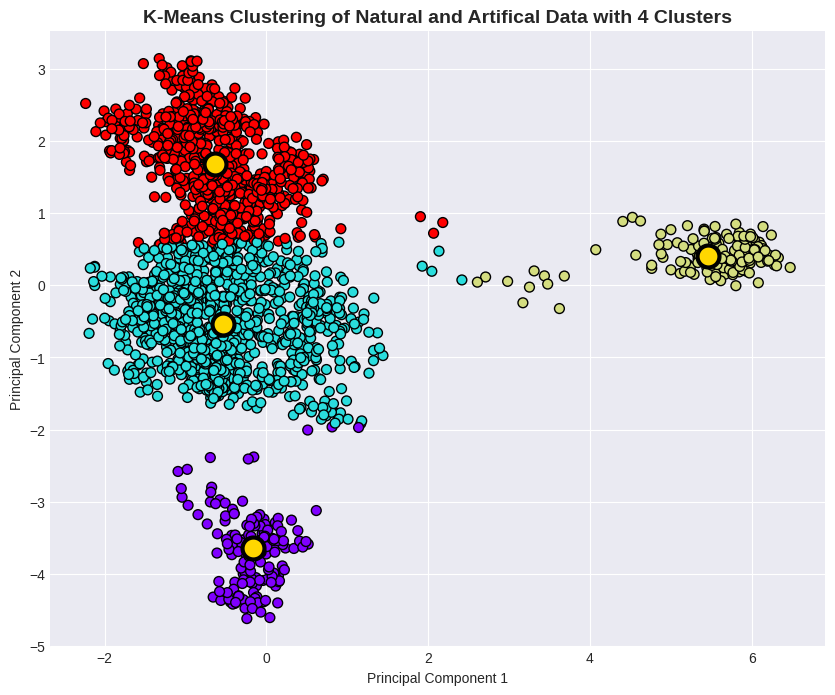

In [15]:
# Combining natural and artificial PCA data for clustering
combined_data = np.vstack((principal_components_natural, principal_components_artificial))

# Fit the model to the data
est.fit(combined_data)

# Predict the cluster labels for the data points
y_kmeans = est.predict(combined_data)

# Plot the clustered data points with color coding for clusters
plt.figure(figsize=(10, 8))
plt.scatter(combined_data[:, 0], combined_data[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)
plt.title('K-Means Clustering of Natural and Artifical Data with 4 Clusters', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

**Question 3:** Are the artifical and natural datasets seperated into different clusters? **No**

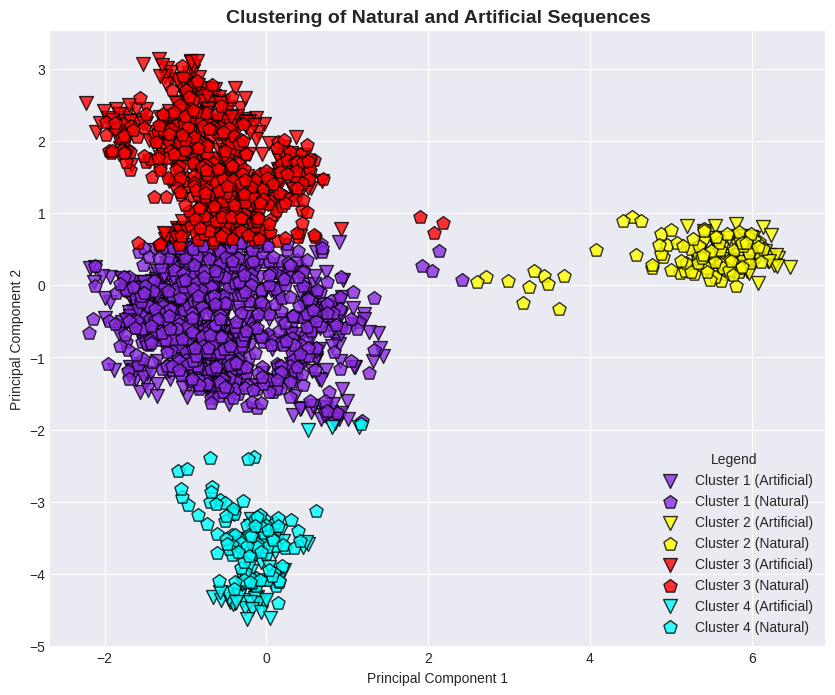

In [16]:
plt.figure(figsize=(10, 8))

# Define markers and cluster colors
markers = {'artificial': 'v', 'natural': 'p'}
cluster_colors = ['blueviolet',  'yellow', 'red','cyan']  # Customize as needed
sequence_labels = {'artificial': 'Artificial', 'natural': 'Natural'}

# Combine data for indexing
combined_sequences = np.vstack((principal_components_natural, principal_components_artificial))
sequence_types = ['natural'] * len(principal_components_natural) + ['artificial'] * len(principal_components_artificial)

# Fit KMeans clustering for combined data
est.fit(combined_sequences)
y_kmeans_combined = est.predict(combined_sequences)

# Plot each combination of sequence type and cluster
for cluster in range(4):  # Loop over clusters
    for seq_type, marker in markers.items():  # Loop over sequence types
        indices = [
            i for i, (label, seq) in enumerate(zip(y_kmeans_combined, sequence_types))
            if label == cluster and seq == seq_type
        ]
        plt.scatter(
            combined_sequences[indices, 0],
            combined_sequences[indices, 1],
            c=cluster_colors[cluster],  # Color based on the cluster
            marker=marker,  # Marker based on sequence type
            edgecolor='black',  # Add an outline to the markers
            linewidth=1,
            s=100,  # Size for clear visibility
            label=f"Cluster {cluster+1} ({sequence_labels[seq_type]})",
            alpha=0.8
        )

# Add legend with unique entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates
plt.legend(by_label.values(), by_label.keys(), title="Legend", loc='best', fontsize=10)

# Add title and axis labels
plt.title('Clustering of Natural and Artificial Sequences', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


They occupy the same space and are not distinguished by any of the clusters.This indicates **good quality** in the artificial data, as it aligns well with the patterns and structures present in the natural data.

# **Task 4:**

We now want to test the quality of the artificial data's functionality descriprion. To do so we use a **logistic regression classifier**. We do the training on the natural data and then we make predictions on the artificial data. Finally, test the artificial's data descriprion with the classifiers prediction via the confusion matrix.

Now, I will be creating a new dataset where the functionality is mapped into a binary output.


In [17]:

# Convert 'functional_true' / 'functional_false' into numerical labels: 1 / 0

# Natural sequences
nat_functionality = []
for seq_record in nat_sequences:
    # The last token in seq_record.description is 'functional_true' or 'functional_false'
    status = seq_record.description.split()[-1]
    if status == 'functional_true':
        nat_functionality.append(1)
    else:
        nat_functionality.append(0)

# Artificial sequences
art_functionality = []
for seq_record in art_sequences:
    status = seq_record.description.split()[-1]
    if status == 'functional_true':
        art_functionality.append(1)
    else:
        art_functionality.append(0)

print(nat_sequences[1])

ID: sequence_2
Name: sequence_2
Description: sequence_2 functional_false
Number of features: 0
Seq('---DERIQALRKEVDRVNREILRLLSERGRLVQEIGRLQTELGLPHYDPKREEE...Q--')


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix: 
 [[415  89]
 [126 373]]


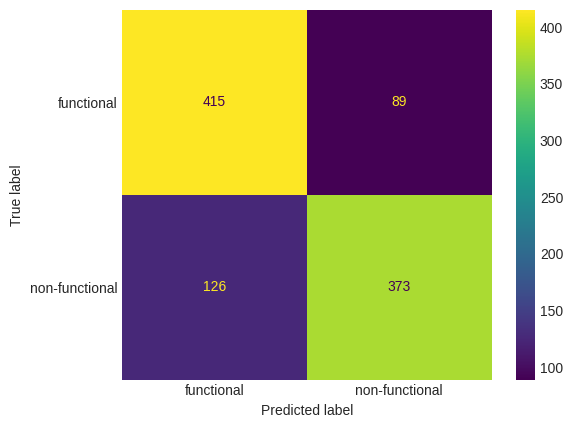


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       504
           1       0.81      0.75      0.78       499

    accuracy                           0.79      1003
   macro avg       0.79      0.79      0.79      1003
weighted avg       0.79      0.79      0.79      1003



In [18]:
# Initialize and fit the logistic regression model on the training data
model_c = LogisticRegression()
model_c.fit(reshaped_nat_encoded_sequences, nat_functionality)


# Label the test data's input (x) and output (y)
X_test = reshaped_art_encoded_sequences
y_test = art_functionality

# Make predictions on the validation set
y_pred = model_c.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix: \n", cm)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['functional', 'non-functional'])
disp.plot()

# Update plot settings
plt.grid(False)
plt.show()

# Print the classification report
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)

Now, we are **adjusting a cutoff threshold** in the logistic regression model.

Confusion Matrix at threshold 0.3 
 [[397 107]
 [ 94 405]]


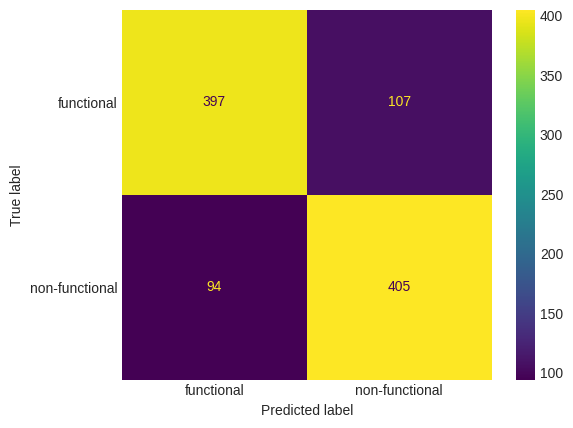


Classification Report at threshold 0.3
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       504
           1       0.79      0.81      0.80       499

    accuracy                           0.80      1003
   macro avg       0.80      0.80      0.80      1003
weighted avg       0.80      0.80      0.80      1003



In [19]:
# Calculate prediction probabilities
prob = model_c.predict_proba(X_test)

# Adjust the cutoff threshold
threshold = 0.3 # You can change this to test different thresholds

y_pred_final = (prob[:, 1] >= threshold).astype(int)

# Evaluate performance with the adjusted predictions
cm_adjusted = confusion_matrix(y_test, y_pred_final)
report_adjusted = classification_report(y_test, y_pred_final)

# Display the results
print(f"Confusion Matrix at threshold {threshold} \n", cm_adjusted)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_adjusted, display_labels=['functional', 'non-functional'])
disp.plot()

# Update plot settings
plt.grid(False)
plt.show()

print("\nClassification Report at threshold", threshold)
print(report_adjusted)

By adjusting the cutoff threshold in the logistic regression model, we achieve improved results.

We generated the confusion matrix for the classification process. All evaluation metrics (F1 score, precision, and recall) demonstrate strong performance, indicating that the classifier is performing well across both classes.

In our case, this indicates that the artificial descriptions are well-generated, as they align closely with the classifier's predictions, demonstrating their quality and relevance to the natural data.

# **Task 5:**

We are generating a set of artificial amino-acid sequences by sampling from the natural sequences, using **variational autoencoder** algorithm.

--------- Training VAE ---------
Epoch 1/30
31/31 [==============================] - 3s 25ms/step - loss: 6227.6270 - val_loss: 6960.3662
Epoch 2/30
31/31 [==============================] - 0s 16ms/step - loss: 5264.0908 - val_loss: 6841.9673
Epoch 3/30
31/31 [==============================] - 1s 16ms/step - loss: 5101.7847 - val_loss: 6864.9224
Epoch 4/30
31/31 [==============================] - 0s 15ms/step - loss: 4825.8252 - val_loss: 6785.1128
Epoch 5/30
31/31 [==============================] - 1s 17ms/step - loss: 4459.5986 - val_loss: 6725.5869
Epoch 6/30
31/31 [==============================] - 0s 16ms/step - loss: 4123.1538 - val_loss: 6658.5068
Epoch 7/30
31/31 [==============================] - 1s 16ms/step - loss: 3869.2354 - val_loss: 6674.9585
Epoch 8/30
31/31 [==============================] - 1s 17ms/step - loss: 3662.3374 - val_loss: 6644.4668
Epoch 9/30
31/31 [==============================] - 1s 18ms/step - loss: 3473.8740 - val_loss: 6652.2222
Epoch 10/30
31/31 [===

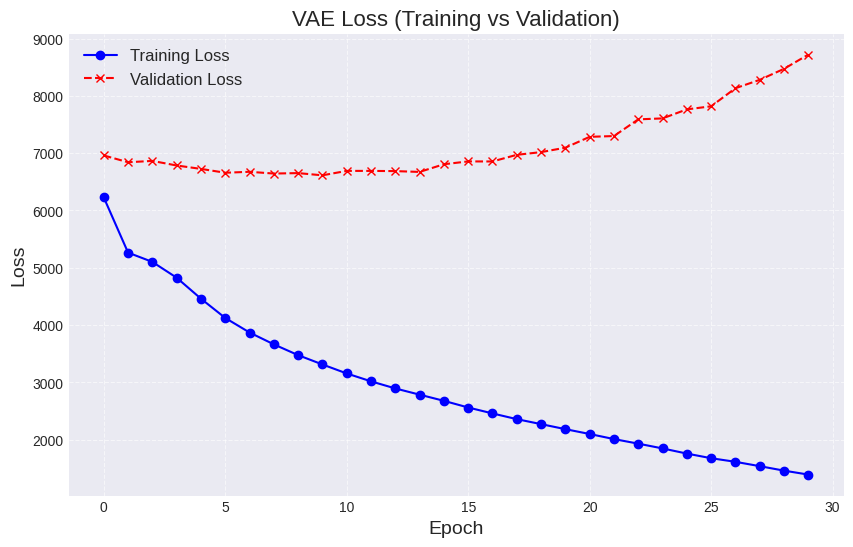

32/32 [==============================] - 0s 2ms/step


In [20]:
#####################################
# Generating artificial sequences using a Variational AutoEncoder
#####################################

# 1) Prepare one-hot data for training the VAE
#    We use the natural sequences as training data for our VAE.
#    They are already one-hot encoded in `nat_encoded_sequences`.

# Flatten the one-hot sequences from shape (N, 96, 20) to (N, 96*20)
nat_encoded_sequences_vae = nat_encoded_sequences.reshape(len(nat_encoded_sequences), -1).astype('float32')

# Define some hyperparameters for the VAE
original_dim = 96 * 20   # 96 positions, 20 channels
intermediate_dim = 200   # size of hidden layers
latent_dim = 60         # Reduced latent space dimension for efficiency
batch_size = 30         # Increased batch size for faster training
epochs = 30            # Training epochs
learning_rate = 1e-3
validation_split=0.2
beta = 1


# 2) Define the encoder part of the VAE
inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
x = layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# 3) Define the decoder part of the VAE
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim, activation='relu')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)  # shape=(None, 96*20)

# Define decoder model
decoder = Model(latent_inputs, outputs, name='decoder')


# 4) Define the VAE model that ties encoder & decoder
vae_outputs = decoder(encoder(inputs)[2])  # decode z (the sampled latent)
vae = Model(inputs, vae_outputs, name='vae')


# 5) Define the VAE loss: reconstruction term + KL divergence term
reconstruction_loss = tf.reduce_sum(
    tf.keras.losses.categorical_crossentropy(
        tf.reshape(inputs, (-1, 20)), tf.reshape(vae_outputs, (-1, 20))
    ), axis=-1
)
kl_loss = -0.5 * tf.reduce_sum(
    (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=-1
)

vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)



# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=optimizer)


# 6) Train the VAE on natural sequences
print("--------- Training VAE ---------")

history = vae.fit(
    nat_encoded_sequences_vae,
    nat_encoded_sequences_vae,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split
)


# 7) Plot Training vs. Validation Loss as Two Lines
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(history.history['loss'], label="Training Loss", color="blue", linestyle='-', marker='o')

# Plot Validation Loss
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle='--', marker='x')

# Add title and labels
plt.title("VAE Loss (Training vs Validation)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# 8) Sample from the latent space & decode into new protein sequences
def generate_new_sequences(num_seqs):
    """
    Generate new sequences from the trained VAE.
    Returns the decoded one-hot sequences in shape (num_seqs, 96, 20).
    """
    # Randomly sample points in the latent space
    z_samples = tf.random.normal(shape=(num_seqs, latent_dim))
    # Decode to get predictions in shape (num_seqs, 96*20)
    decoded = decoder.predict(z_samples)

    # Convert the continuous outputs in [0,1] to one-hot vectors using argmax over the last dimension of size 20.
    # But first we reshape it to (num_seqs, 96, 20)
    decoded = decoded.reshape(num_seqs, 96, 20)

    # We apply argmax across the 20 possible amino acids, resulting in an integer array (num_seqs, 96).
    argmax_decoded = tf.argmax(decoded, axis=-1).numpy()

    # Convert argmax back into one-hot by scatter or simply keep argmax as the representative amino acid index. We return both forms.

    # Re-build one-hot from argmax
    one_hot_result = np.zeros_like(decoded)
    for i in range(num_seqs):
        for pos in range(96):
            aa_idx = argmax_decoded[i, pos]
            one_hot_result[i, pos, aa_idx] = 1.0

    return one_hot_result, argmax_decoded


# -----------------------------------------------------------------------
#               GENERATING NEW SEQUENCES WITH THE VAE
# -----------------------------------------------------------------------

gen_encoded_sequences, generated_indices = generate_new_sequences(num_seqs=1003)


The result of the loss function comparison graph indicates **overfitting**.

We are redoing tasks 2 and 3 with the data we generated by VAE. Here, we are checking wether or not the natural and the VAE generated data are occupying the same region in the dimensionally reduced PCA space. Moreover, we are checking if they alter the clustering of the natural data.

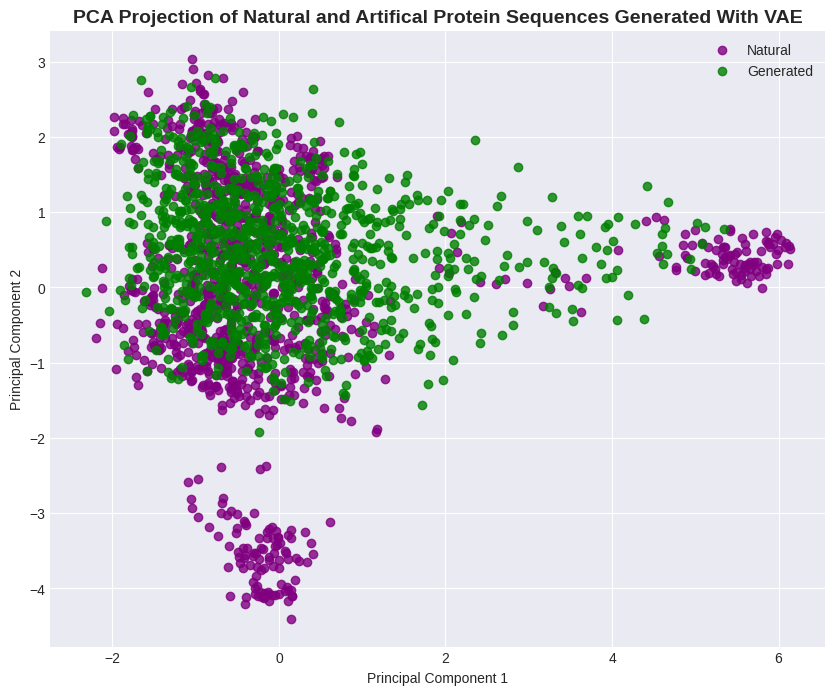

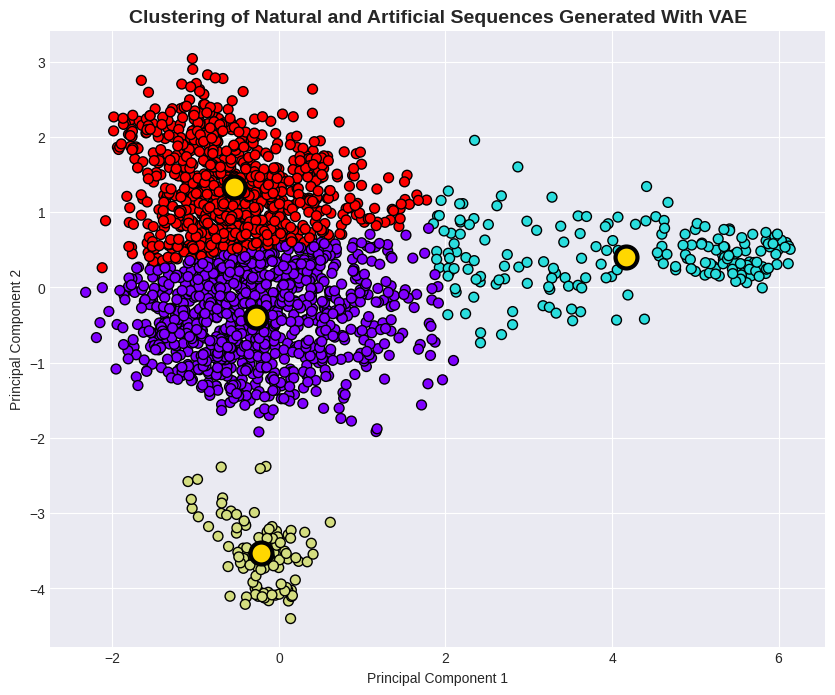

In [22]:

#####################################
# REDO Task 2:
#####################################

### New Artificial Data = Generated Data

# Reshape 3D array to a 2D array
reshaped_gen_encoded_sequences = gen_encoded_sequences.reshape(len(gen_encoded_sequences), 96 * 20)

# Find the PCA's of generated data for the PCA model fitted earlier for the natural data
principal_components_generated = pca.transform(reshaped_gen_encoded_sequences)

# Plot both natural and generated sequences in the same PCA plot for comparison
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(principal_components_natural[:, 0], principal_components_natural[:, 1], c='purple', alpha=0.8, label='Natural')
# Generated sequences
plt.scatter(principal_components_generated[:, 0], principal_components_generated[:, 1], color='green', alpha=0.8, label='Generated')

plt.title('PCA Projection of Natural and Artifical Protein Sequences Generated With VAE' , fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


#####################################
# REDO Task 3 using K-means clustering :
#####################################


# Initialize KMeans with 4 clusters
est = KMeans(4)

# Combining natural and generated PCA data for clustering
combined_data = np.vstack((principal_components_natural, principal_components_generated))

# Fit the model to the data
est.fit(combined_data)

# Predict the cluster labels for the data points
y_kmeans = est.predict(combined_data)

# Plot
plt.figure(figsize=(10, 8))

# Plot the clustered data points with color coding for clusters
plt.scatter(combined_data[:, 0], combined_data[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)

# Add title and axis labels
plt.title('Clustering of Natural and Artificial Sequences Generated With VAE', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


Implementing **Dropout**

--------- Training VAE ---------
Epoch 1/30
31/31 [==============================] - 3s 23ms/step - loss: 6297.8896 - val_loss: 6697.1353
Epoch 2/30
31/31 [==============================] - 1s 18ms/step - loss: 5307.0044 - val_loss: 6893.5234
Epoch 3/30
31/31 [==============================] - 1s 16ms/step - loss: 5219.8818 - val_loss: 6882.0391
Epoch 4/30
31/31 [==============================] - 1s 18ms/step - loss: 5098.0479 - val_loss: 6800.0435
Epoch 5/30
31/31 [==============================] - 1s 16ms/step - loss: 4875.8511 - val_loss: 6814.0269
Epoch 6/30
31/31 [==============================] - 1s 28ms/step - loss: 4626.0347 - val_loss: 6754.7783
Epoch 7/30
31/31 [==============================] - 1s 29ms/step - loss: 4407.7417 - val_loss: 6707.9961
Epoch 8/30
31/31 [==============================] - 1s 28ms/step - loss: 4214.6421 - val_loss: 6681.5059
Epoch 9/30
31/31 [==============================] - 1s 30ms/step - loss: 4057.4646 - val_loss: 6695.3716
Epoch 10/30
31/31 [===

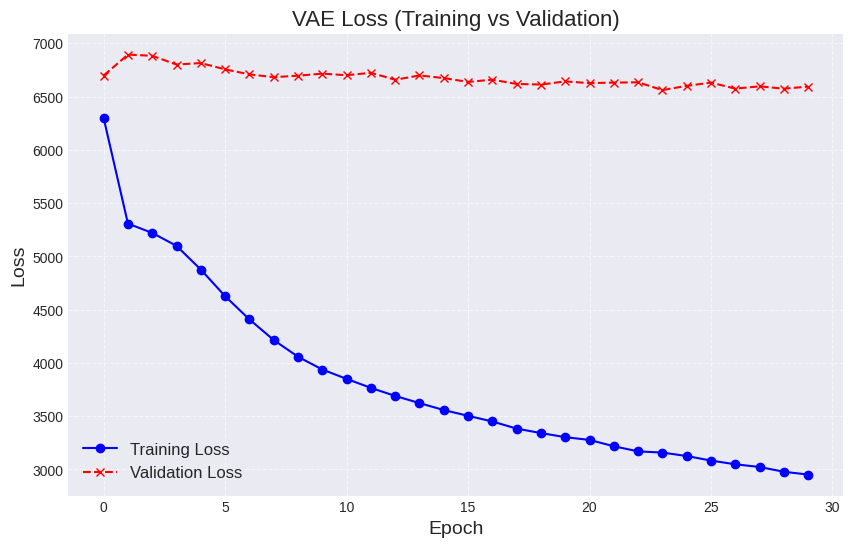

32/32 [==============================] - 0s 4ms/step


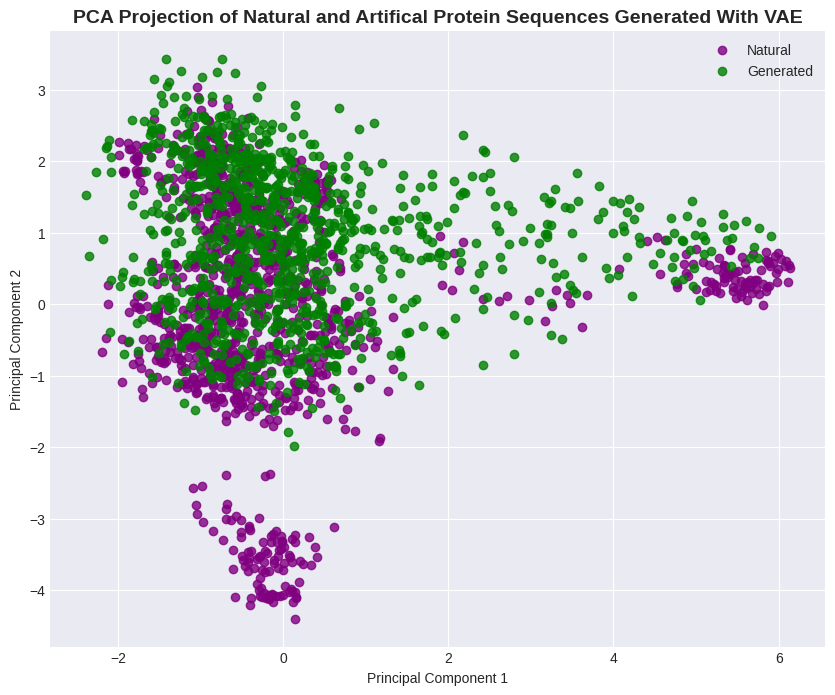

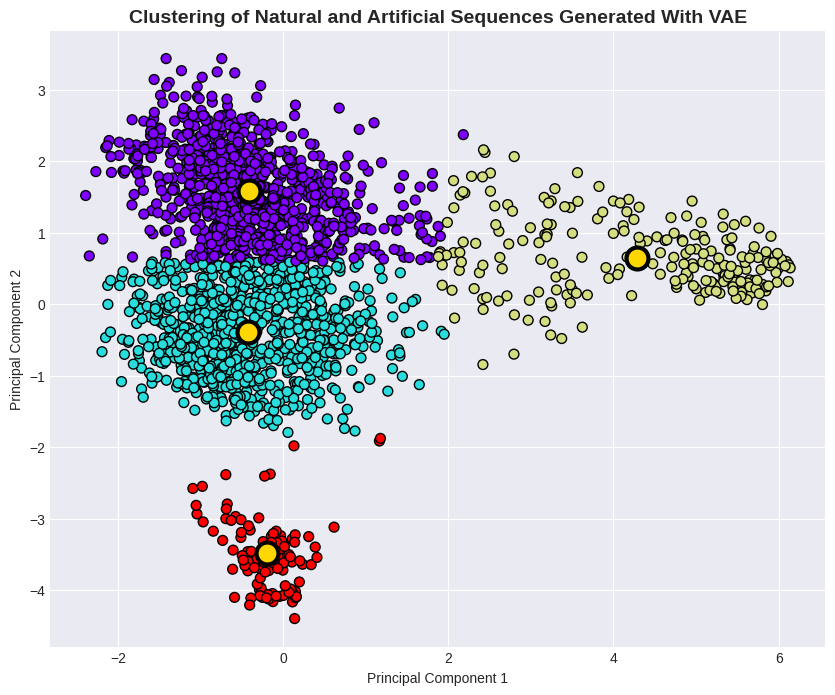

In [23]:
#####################################
# Generating artificial sequences using a Variational AutoEncoder
#####################################

# 1) Prepare one-hot data for training the VAE
#    We use the natural sequences as training data for our VAE.
#    They are already one-hot encoded in `nat_encoded_sequences`.

# Flatten the one-hot sequences from shape (N, 96, 20) to (N, 96*20)
nat_encoded_sequences_vae = nat_encoded_sequences.reshape(len(nat_encoded_sequences), -1).astype('float32')

# Define some hyperparameters for the VAE
original_dim = 96 * 20   # 96 positions, 20 channels
intermediate_dim = 200   # size of hidden layers
latent_dim = 60         # Reduced latent space dimension for efficiency
batch_size = 30         # Increased batch size for faster training
epochs = 30            # Training epochs
learning_rate = 1e-3
validation_split=0.2
beta = 1
dropout_rate = 0.2


# 2) Define the encoder part of the VAE
inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
x = Dropout(dropout_rate)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = Dropout(dropout_rate)(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# 3) Define the decoder part of the VAE
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(dropout_rate)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = Dropout(dropout_rate)(x)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)  # shape=(None, 96*20)

# Define decoder model
decoder = Model(latent_inputs, outputs, name='decoder')


# 4) Define the VAE model that ties encoder & decoder
vae_outputs = decoder(encoder(inputs)[2])  # decode z (the sampled latent)
vae = Model(inputs, vae_outputs, name='vae')


# 5) Define the VAE loss: reconstruction term + KL divergence term
reconstruction_loss = tf.reduce_sum(
    tf.keras.losses.categorical_crossentropy(
        tf.reshape(inputs, (-1, 20)), tf.reshape(vae_outputs, (-1, 20))
    ), axis=-1
)
kl_loss = -0.5 * tf.reduce_sum(
    (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=-1
)

vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)



# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=optimizer)


# 6) Train the VAE on natural sequences
print("--------- Training VAE ---------")

history = vae.fit(
    nat_encoded_sequences_vae,
    nat_encoded_sequences_vae,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split
)


# 7) Plot Training vs. Validation Loss as Two Lines
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(history.history['loss'], label="Training Loss", color="blue", linestyle='-', marker='o')

# Plot Validation Loss
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle='--', marker='x')

# Add title and labels
plt.title("VAE Loss (Training vs Validation)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# 8) Sample from the latent space & decode into new protein sequences
def generate_new_sequences(num_seqs):
    """
    Generate new sequences from the trained VAE.
    Returns the decoded one-hot sequences in shape (num_seqs, 96, 20).
    """
    # Randomly sample points in the latent space
    z_samples = tf.random.normal(shape=(num_seqs, latent_dim))
    # Decode to get predictions in shape (num_seqs, 96*20)
    decoded = decoder.predict(z_samples)

    # Convert the continuous outputs in [0,1] to one-hot vectors using argmax over the last dimension of size 20.
    # But first we reshape it to (num_seqs, 96, 20)
    decoded = decoded.reshape(num_seqs, 96, 20)

    # We apply argmax across the 20 possible amino acids, resulting in an integer array (num_seqs, 96).
    argmax_decoded = tf.argmax(decoded, axis=-1).numpy()

    # Convert argmax back into one-hot by scatter or simply keep argmax as the representative amino acid index. We return both forms.

    # Re-build one-hot from argmax
    one_hot_result = np.zeros_like(decoded)
    for i in range(num_seqs):
        for pos in range(96):
            aa_idx = argmax_decoded[i, pos]
            one_hot_result[i, pos, aa_idx] = 1.0

    return one_hot_result, argmax_decoded


# -----------------------------------------------------------------------
#               GENERATING NEW SEQUENCES WITH THE VAE
# -----------------------------------------------------------------------

gen_encoded_sequences, generated_indices = generate_new_sequences(num_seqs=1003)


#####################################
# REDO Task 2:
#####################################

### New Artificial Data = Generated Data

# Reshape 3D array to a 2D array
reshaped_gen_encoded_sequences = gen_encoded_sequences.reshape(len(gen_encoded_sequences), 96 * 20)

# Find the PCA's of generated data for the PCA model fitted earlier for the natural data
principal_components_generated = pca.transform(reshaped_gen_encoded_sequences)

# Plot both natural and generated sequences in the same PCA plot for comparison
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(principal_components_natural[:, 0], principal_components_natural[:, 1], c='purple', alpha=0.8, label='Natural')
# Generated sequences
plt.scatter(principal_components_generated[:, 0], principal_components_generated[:, 1], color='green', alpha=0.8, label='Generated')

plt.title('PCA Projection of Natural and Artifical Protein Sequences Generated With VAE' , fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


#####################################
# REDO Task 3 using K-means clustering :
#####################################


# Initialize KMeans with 4 clusters
est = KMeans(4)

# Combining natural and generated PCA data for clustering
combined_data = np.vstack((principal_components_natural, principal_components_generated))

# Fit the model to the data
est.fit(combined_data)

# Predict the cluster labels for the data points
y_kmeans = est.predict(combined_data)

# Plot
plt.figure(figsize=(10, 8))

# Plot the clustered data points with color coding for clusters
plt.scatter(combined_data[:, 0], combined_data[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)

# Add title and axis labels
plt.title('Clustering of Natural and Artificial Sequences Generated With VAE', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Implementing **batch normalisation**

--------- Training VAE ---------
Epoch 1/30
31/31 [==============================] - 4s 28ms/step - loss: 8045.2793 - val_loss: 7712.2954
Epoch 2/30
31/31 [==============================] - 1s 17ms/step - loss: 7596.1982 - val_loss: 7578.6714
Epoch 3/30
31/31 [==============================] - 1s 18ms/step - loss: 6953.9551 - val_loss: 7210.2935
Epoch 4/30
31/31 [==============================] - 1s 19ms/step - loss: 6216.5186 - val_loss: 6788.3887
Epoch 5/30
31/31 [==============================] - 1s 26ms/step - loss: 5566.5752 - val_loss: 6676.4395
Epoch 6/30
31/31 [==============================] - 1s 28ms/step - loss: 5060.5635 - val_loss: 6680.4624
Epoch 7/30
31/31 [==============================] - 1s 31ms/step - loss: 4680.4209 - val_loss: 6688.0698
Epoch 8/30
31/31 [==============================] - 1s 32ms/step - loss: 4428.6719 - val_loss: 6635.7798
Epoch 9/30
31/31 [==============================] - 1s 23ms/step - loss: 4214.9272 - val_loss: 6705.2920
Epoch 10/30
31/31 [===

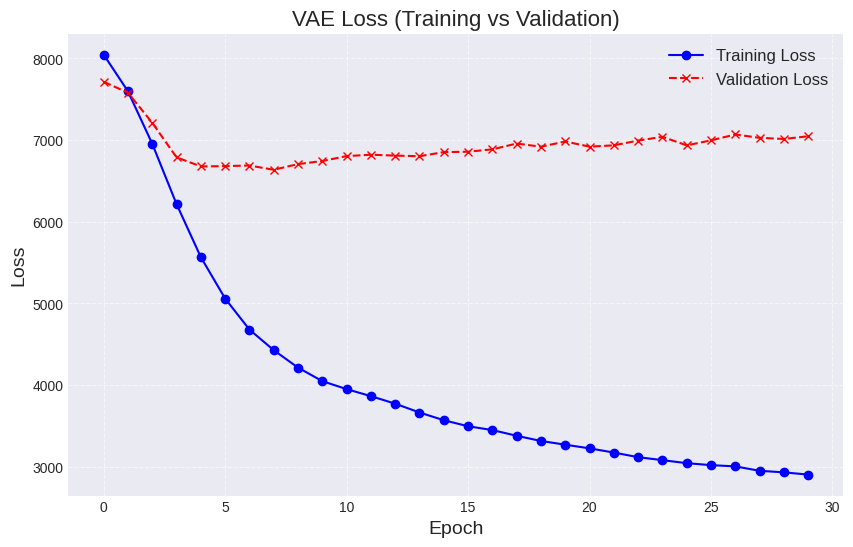

32/32 [==============================] - 0s 4ms/step


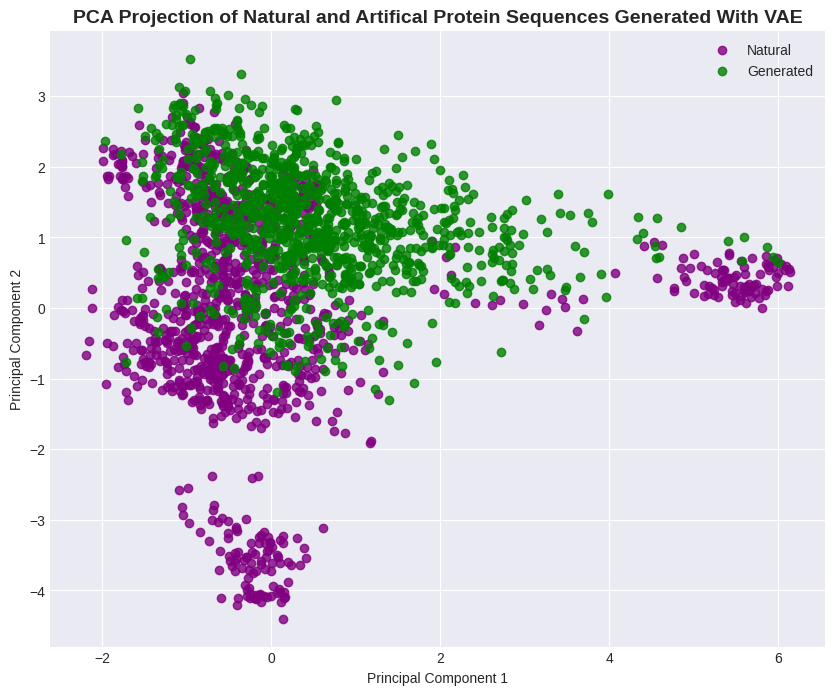

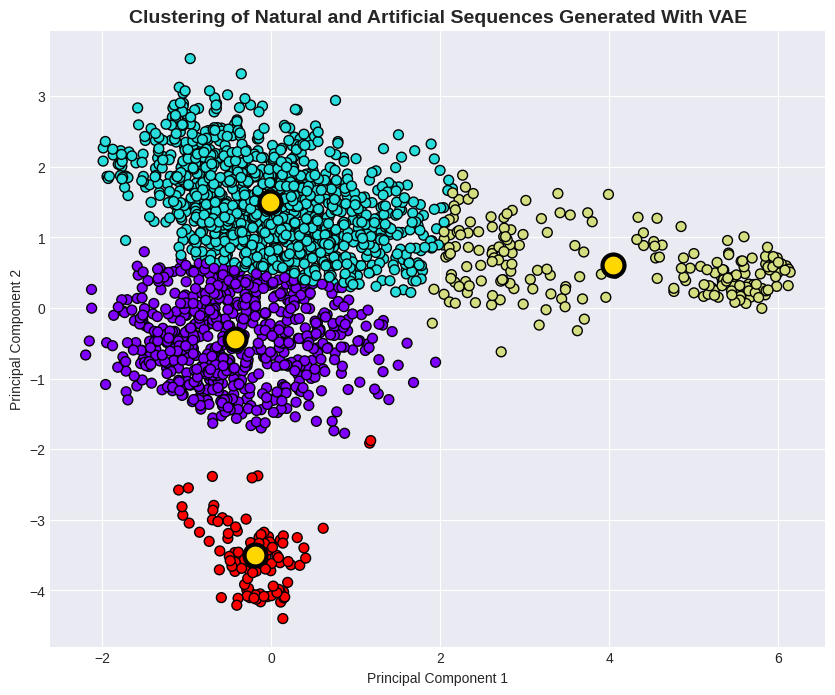

In [24]:
#####################################
# Generating artificial sequences using a Variational AutoEncoder
#####################################

# 1) Prepare one-hot data for training the VAE
#    We use the natural sequences as training data for our VAE.
#    They are already one-hot encoded in `nat_encoded_sequences`.

# Flatten the one-hot sequences from shape (N, 96, 20) to (N, 96*20)
nat_encoded_sequences_vae = nat_encoded_sequences.reshape(len(nat_encoded_sequences), -1).astype('float32')

# Define some hyperparameters for the VAE
original_dim = 96 * 20   # 96 positions, 20 channels
intermediate_dim = 200   # size of hidden layers
latent_dim = 60         # Reduced latent space dimension for efficiency
batch_size = 30         # Increased batch size for faster training
epochs = 30            # Training epochs
learning_rate = 1e-3
validation_split=0.2
beta = 1
dropout_rate = 0.2


# 2) Define the encoder part of the VAE
inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# 3) Define the decoder part of the VAE
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)  # shape=(None, 96*20)

# Define decoder model
decoder = Model(latent_inputs, outputs, name='decoder')


# 4) Define the VAE model that ties encoder & decoder
vae_outputs = decoder(encoder(inputs)[2])  # decode z (the sampled latent)
vae = Model(inputs, vae_outputs, name='vae')


# 5) Define the VAE loss: reconstruction term + KL divergence term
reconstruction_loss = tf.reduce_sum(
    tf.keras.losses.categorical_crossentropy(
        tf.reshape(inputs, (-1, 20)), tf.reshape(vae_outputs, (-1, 20))
    ), axis=-1
)
kl_loss = -0.5 * tf.reduce_sum(
    (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=-1
)

vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)



# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=optimizer)


# 6) Train the VAE on natural sequences
print("--------- Training VAE ---------")

history = vae.fit(
    nat_encoded_sequences_vae,
    nat_encoded_sequences_vae,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split
)


# 7) Plot Training vs. Validation Loss as Two Lines
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(history.history['loss'], label="Training Loss", color="blue", linestyle='-', marker='o')

# Plot Validation Loss
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle='--', marker='x')

# Add title and labels
plt.title("VAE Loss (Training vs Validation)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# 8) Sample from the latent space & decode into new protein sequences
def generate_new_sequences(num_seqs):
    """
    Generate new sequences from the trained VAE.
    Returns the decoded one-hot sequences in shape (num_seqs, 96, 20).
    """
    # Randomly sample points in the latent space
    z_samples = tf.random.normal(shape=(num_seqs, latent_dim))
    # Decode to get predictions in shape (num_seqs, 96*20)
    decoded = decoder.predict(z_samples)

    # Convert the continuous outputs in [0,1] to one-hot vectors using argmax over the last dimension of size 20.
    # But first we reshape it to (num_seqs, 96, 20)
    decoded = decoded.reshape(num_seqs, 96, 20)

    # We apply argmax across the 20 possible amino acids, resulting in an integer array (num_seqs, 96).
    argmax_decoded = tf.argmax(decoded, axis=-1).numpy()

    # Convert argmax back into one-hot by scatter or simply keep argmax as the representative amino acid index. We return both forms.

    # Re-build one-hot from argmax
    one_hot_result = np.zeros_like(decoded)
    for i in range(num_seqs):
        for pos in range(96):
            aa_idx = argmax_decoded[i, pos]
            one_hot_result[i, pos, aa_idx] = 1.0

    return one_hot_result, argmax_decoded


# -----------------------------------------------------------------------
#               GENERATING NEW SEQUENCES WITH THE VAE
# -----------------------------------------------------------------------

gen_encoded_sequences, generated_indices = generate_new_sequences(num_seqs=1003)


#####################################
# REDO Task 2:
#####################################

### New Artificial Data = Generated Data

# Reshape 3D array to a 2D array
reshaped_gen_encoded_sequences = gen_encoded_sequences.reshape(len(gen_encoded_sequences), 96 * 20)

# Find the PCA's of generated data for the PCA model fitted earlier for the natural data
principal_components_generated = pca.transform(reshaped_gen_encoded_sequences)

# Plot both natural and generated sequences in the same PCA plot for comparison
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(principal_components_natural[:, 0], principal_components_natural[:, 1], c='purple', alpha=0.8, label='Natural')
# Generated sequences
plt.scatter(principal_components_generated[:, 0], principal_components_generated[:, 1], color='green', alpha=0.8, label='Generated')

plt.title('PCA Projection of Natural and Artifical Protein Sequences Generated With VAE' , fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


#####################################
# REDO Task 3 using K-means clustering :
#####################################


# Initialize KMeans with 4 clusters
est = KMeans(4)

# Combining natural and generated PCA data for clustering
combined_data = np.vstack((principal_components_natural, principal_components_generated))

# Fit the model to the data
est.fit(combined_data)

# Predict the cluster labels for the data points
y_kmeans = est.predict(combined_data)

# Plot
plt.figure(figsize=(10, 8))

# Plot the clustered data points with color coding for clusters
plt.scatter(combined_data[:, 0], combined_data[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)

# Add title and axis labels
plt.title('Clustering of Natural and Artificial Sequences Generated With VAE', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

The result of the loss function comparison graph indicates **underfitting**. Hence, I went from overfitting to underfitting. So lets try to increase the fitting from this point on. For this, I am playing with the hyperparameters first.


--------- Training VAE ---------
Epoch 1/50
25/25 [==============================] - 9s 72ms/step - loss: 8854.2529 - val_loss: 8458.9473
Epoch 2/50
25/25 [==============================] - 1s 49ms/step - loss: 8787.2539 - val_loss: 8456.5967
Epoch 3/50
25/25 [==============================] - 1s 42ms/step - loss: 8705.0654 - val_loss: 8453.6074
Epoch 4/50
25/25 [==============================] - 1s 29ms/step - loss: 8595.3740 - val_loss: 8446.8018
Epoch 5/50
25/25 [==============================] - 1s 29ms/step - loss: 8481.9844 - val_loss: 8435.1934
Epoch 6/50
25/25 [==============================] - 1s 33ms/step - loss: 8360.3086 - val_loss: 8412.3379
Epoch 7/50
25/25 [==============================] - 1s 34ms/step - loss: 8230.6416 - val_loss: 8382.1953
Epoch 8/50
25/25 [==============================] - 1s 33ms/step - loss: 8070.8101 - val_loss: 8341.3506
Epoch 9/50
25/25 [==============================] - 1s 29ms/step - loss: 7880.5986 - val_loss: 8280.3936
Epoch 10/50
25/25 [===

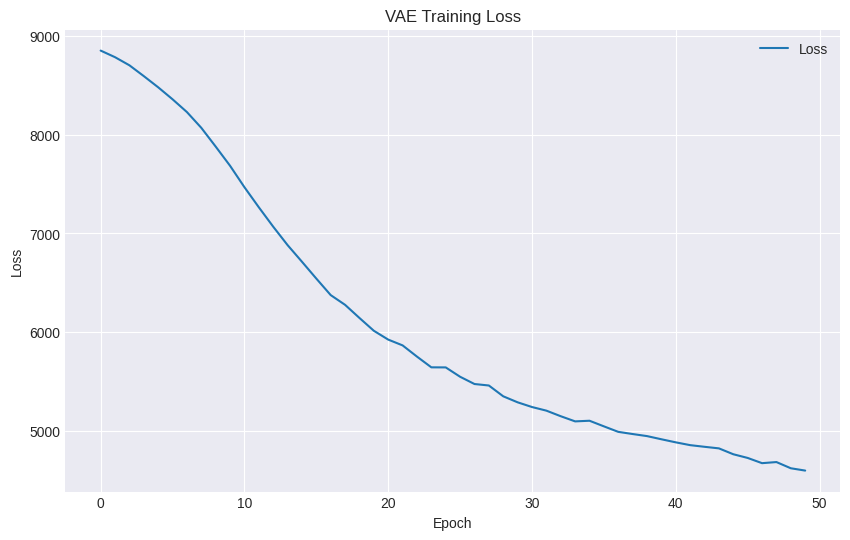

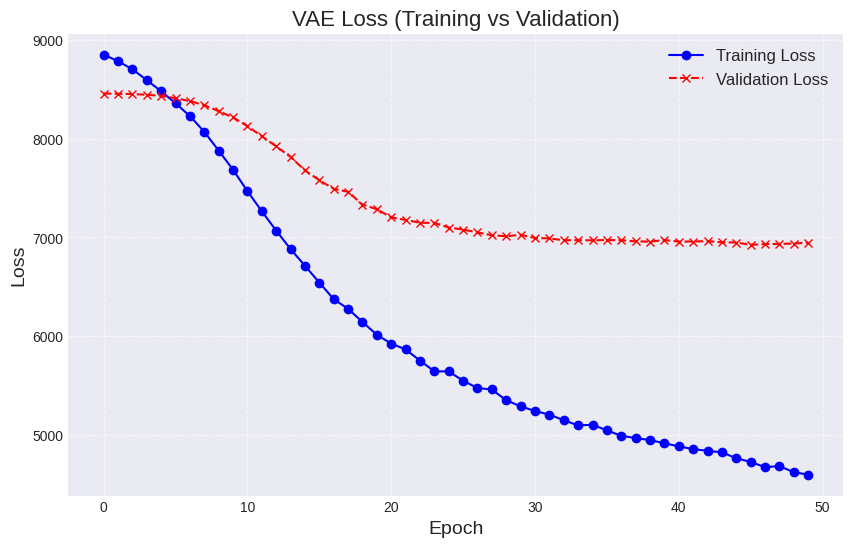

32/32 [==============================] - 0s 6ms/step


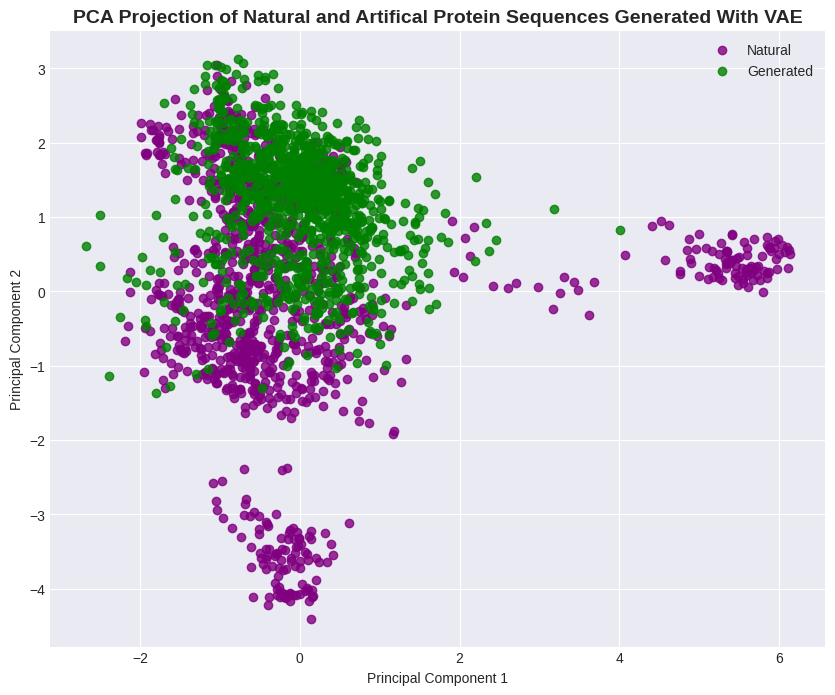

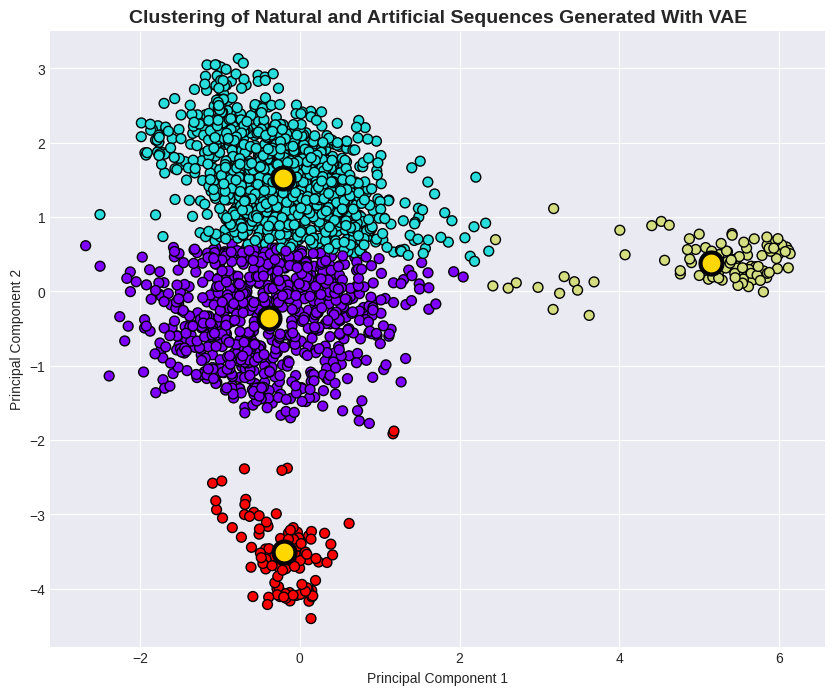

In [ ]:
#####################################
# Generating artificial sequences using a Variational AutoEncoder
#####################################

# 1) Prepare one-hot data for training the VAE
#    We use the natural sequences as training data for our VAE.
#    They are already one-hot encoded in `nat_encoded_sequences`.

# Flatten the one-hot sequences from shape (N, 96, 20) to (N, 96*20)
nat_encoded_sequences_vae = nat_encoded_sequences.reshape(len(nat_encoded_sequences), -1).astype('float32')

# Define some hyperparameters for the VAE
original_dim = 96 * 20   # 96 positions, 20 channels
intermediate_dim = 256   # size of hidden layers
latent_dim = 64         # Reduced latent space dimension for efficiency
batch_size = 32         # Increased batch size for faster training
epochs = 50            # Training epochs
learning_rate = 1e-4*2
validation_split=0.3
beta = 1
dropout_rate = 0.2


# 2) Define the encoder part of the VAE
inputs = layers.Input(shape=(original_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# 3) Define the decoder part of the VAE
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Dense(intermediate_dim, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)

outputs = layers.Dense(original_dim, activation='sigmoid')(x)  # shape=(None, 96*20)

# Define decoder model
decoder = Model(latent_inputs, outputs, name='decoder')


# 4) Define the VAE model that ties encoder & decoder
vae_outputs = decoder(encoder(inputs)[2])  # decode z (the sampled latent)
vae = Model(inputs, vae_outputs, name='vae')


# 5) Define the VAE loss: reconstruction term + KL divergence term
reconstruction_loss = tf.reduce_sum(
    tf.keras.losses.categorical_crossentropy(
        tf.reshape(inputs, (-1, 20)), tf.reshape(vae_outputs, (-1, 20))
    ), axis=-1
)
kl_loss = -0.5 * tf.reduce_sum(
    (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=-1
)

vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)



# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=optimizer)


# 6) Train the VAE on natural sequences
print("--------- Training VAE ---------")

history = vae.fit(
    nat_encoded_sequences_vae,
    nat_encoded_sequences_vae,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split
)


# 7) Plot Training vs. Validation Loss as Two Lines
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(history.history['loss'], label="Training Loss", color="blue", linestyle='-', marker='o')

# Plot Validation Loss
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle='--', marker='x')

# Add title and labels
plt.title("VAE Loss (Training vs Validation)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# 8) Sample from the latent space & decode into new protein sequences
def generate_new_sequences(num_seqs):
    """
    Generate new sequences from the trained VAE.
    Returns the decoded one-hot sequences in shape (num_seqs, 96, 20).
    """
    # Randomly sample points in the latent space
    z_samples = tf.random.normal(shape=(num_seqs, latent_dim))
    # Decode to get predictions in shape (num_seqs, 96*20)
    decoded = decoder.predict(z_samples)

    # Convert the continuous outputs in [0,1] to one-hot vectors using argmax over the last dimension of size 20.
    # But first we reshape it to (num_seqs, 96, 20)
    decoded = decoded.reshape(num_seqs, 96, 20)

    # We apply argmax across the 20 possible amino acids, resulting in an integer array (num_seqs, 96).
    argmax_decoded = tf.argmax(decoded, axis=-1).numpy()

    # Convert argmax back into one-hot by scatter or simply keep argmax as the representative amino acid index. We return both forms.

    # Re-build one-hot from argmax
    one_hot_result = np.zeros_like(decoded)
    for i in range(num_seqs):
        for pos in range(96):
            aa_idx = argmax_decoded[i, pos]
            one_hot_result[i, pos, aa_idx] = 1.0

    return one_hot_result, argmax_decoded


# -----------------------------------------------------------------------
#               GENERATING NEW SEQUENCES WITH THE VAE
# -----------------------------------------------------------------------

gen_encoded_sequences, generated_indices = generate_new_sequences(num_seqs=1003)


#####################################
# REDO Task 2:
#####################################

### New Artificial Data = Generated Data

# Reshape 3D array to a 2D array
reshaped_gen_encoded_sequences = gen_encoded_sequences.reshape(len(gen_encoded_sequences), 96 * 20)

# Find the PCA's of generated data for the PCA model fitted earlier for the natural data
principal_components_generated = pca.transform(reshaped_gen_encoded_sequences)

# Plot both natural and generated sequences in the same PCA plot for comparison
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(principal_components_natural[:, 0], principal_components_natural[:, 1], c='purple', alpha=0.8, label='Natural')
# Generated sequences
plt.scatter(principal_components_generated[:, 0], principal_components_generated[:, 1], color='green', alpha=0.8, label='Generated')

plt.title('PCA Projection of Natural and Artifical Protein Sequences Generated With VAE' , fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


#####################################
# REDO Task 3 using K-means clustering :
#####################################


# Initialize KMeans with 4 clusters
est = KMeans(4)

# Combining natural and generated PCA data for clustering
combined_data = np.vstack((principal_components_natural, principal_components_generated))

# Fit the model to the data
est.fit(combined_data)

# Predict the cluster labels for the data points
y_kmeans = est.predict(combined_data)

# Plot
plt.figure(figsize=(10, 8))

# Plot the clustered data points with color coding for clusters
plt.scatter(combined_data[:, 0], combined_data[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)

# Add title and axis labels
plt.title('Clustering of Natural and Artificial Sequences Generated With VAE', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

The result is much better compared to the first result but the model is still underfitted. To increase the complexity of the model, I am adding now **convolutional layers**.

--------- Training VAE ---------
Epoch 1/50
25/25 [==============================] - 7s 108ms/step - loss: 2772.0837 - val_loss: 2047.3782
Epoch 2/50
25/25 [==============================] - 2s 94ms/step - loss: 2635.8826 - val_loss: 2045.5684
Epoch 3/50
25/25 [==============================] - 2s 97ms/step - loss: 2510.7417 - val_loss: 2037.2245
Epoch 4/50
25/25 [==============================] - 4s 163ms/step - loss: 2372.5032 - val_loss: 1993.3833
Epoch 5/50
25/25 [==============================] - 2s 94ms/step - loss: 2262.0420 - val_loss: 1935.3660
Epoch 6/50
25/25 [==============================] - 2s 88ms/step - loss: 2175.0088 - val_loss: 1876.3394
Epoch 7/50
25/25 [==============================] - 2s 89ms/step - loss: 2099.3855 - val_loss: 1812.2482
Epoch 8/50
25/25 [==============================] - 2s 88ms/step - loss: 2027.7819 - val_loss: 1749.2775
Epoch 9/50
25/25 [==============================] - 3s 129ms/step - loss: 1952.9036 - val_loss: 1685.1089
Epoch 10/50
25/25 [

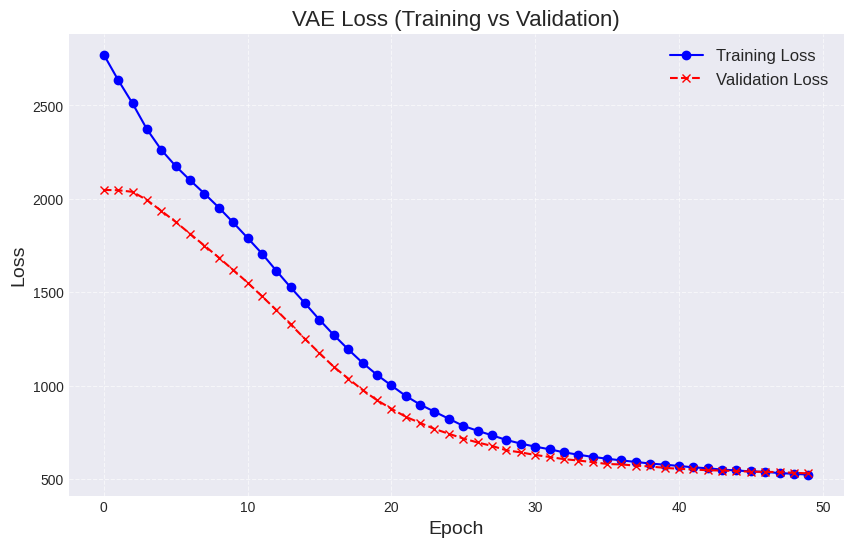

32/32 [==============================] - 0s 8ms/step


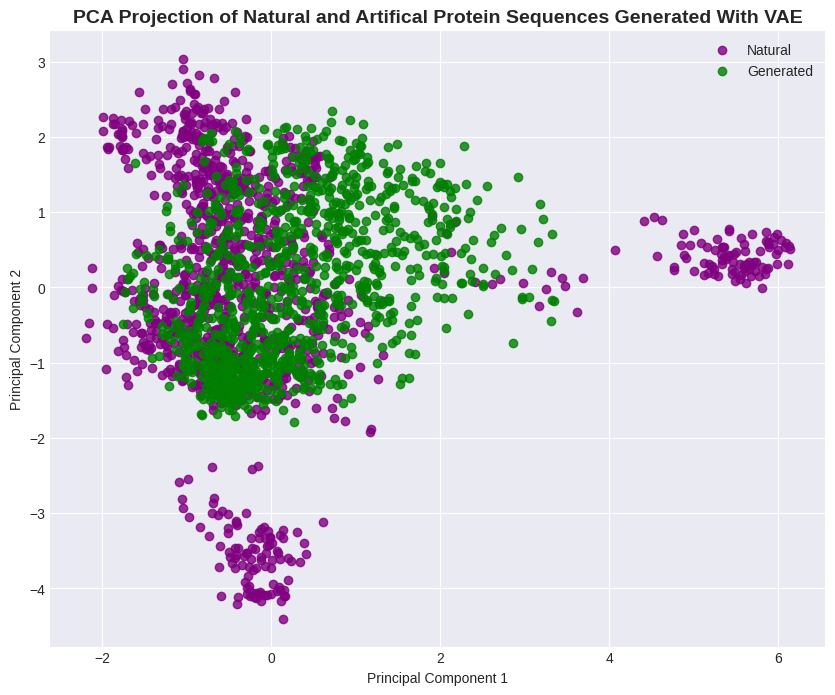

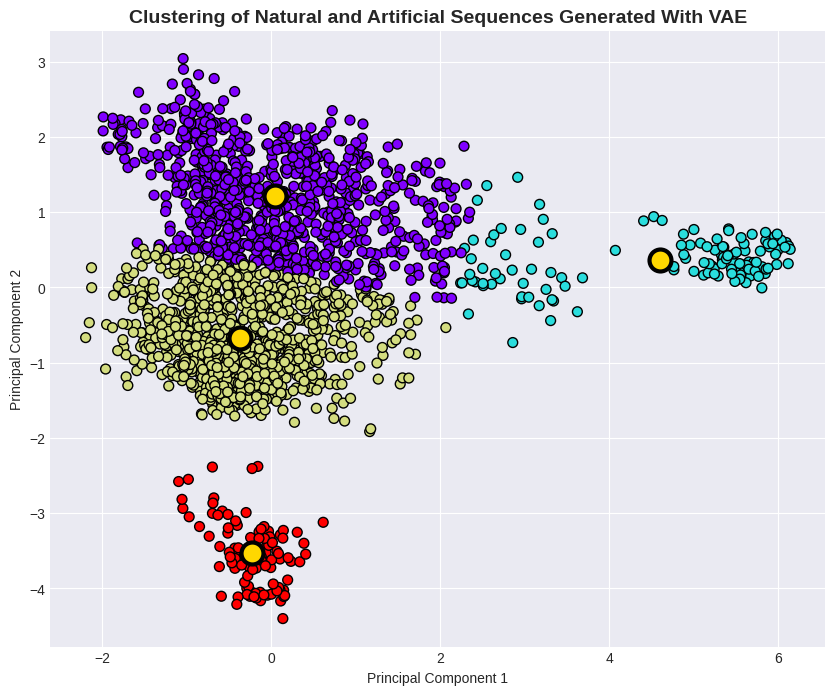

In [25]:
#####################################
# Generating artificial sequences using a Variational AutoEncoder
#####################################

# 1) Prepare one-hot data for training the VAE
#    We use the natural sequences as training data for our VAE.
#    They are already one-hot encoded in `nat_encoded_sequences`.

# Flatten the one-hot sequences from shape (N, 96, 20) to (N, 96*20)
nat_encoded_sequences_vae = nat_encoded_sequences.reshape(len(nat_encoded_sequences), -1).astype('float32')

# Define some hyperparameters for the VAE
original_dim = 96 * 20   # 96 positions, 20 channels
intermediate_dim = 256   # size of hidden layers
latent_dim = 128         # Reduced latent space dimension for efficiency
batch_size = 32         # Increased batch size for faster training
epochs = 50            # Training epochs
learning_rate = 1e-4*2
validation_split=0.3
beta = 1
dropout_rate = 0.2

# 2) Define the encoder part of the VAE
# Encoder with 1D convolutional layers, regularization, and dropout
inputs = layers.Input(shape=(96, 20))
x = layers.Conv1D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# 3) Define the decoder part of the VAE
# Decoder with 1D convolutional layers
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(96 * 64, activation='relu')(latent_inputs)  # Project latent space
x = layers.Reshape((96, 64))(x)  # Reshape to match expected 1D convolutional input
x = layers.Conv1DTranspose(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = layers.Conv1DTranspose(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
outputs = layers.Conv1D(20, 3, activation='sigmoid', padding='same')(x)  # Final output

# Define the decoder model
decoder = Model(latent_inputs, outputs, name='decoder')


# 4) Define the VAE model that ties encoder & decoder
vae_outputs = decoder(encoder(inputs)[2])  # decode z (the sampled latent)
vae = Model(inputs, vae_outputs, name='vae')


# 5) Define the VAE loss: reconstruction term + KL divergence term
reconstruction_loss = tf.reduce_sum(
    tf.keras.losses.binary_crossentropy(
        inputs, vae_outputs
    )
)
kl_loss = -0.5 * tf.reduce_sum(
    (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=-1
)

vae_loss = tf.reduce_mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)


# Compile the VAE
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
vae.compile(optimizer=optimizer)


# 6) Train the VAE on natural sequences
print("--------- Training VAE ---------")


history = vae.fit(
    nat_encoded_sequences.reshape(-1, 96, 20),
    nat_encoded_sequences.reshape(-1, 96, 20),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split
)



# 7) Plot Training vs. Validation Loss as Two Lines
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(history.history['loss'], label="Training Loss", color="blue", linestyle='-', marker='o')

# Plot Validation Loss
plt.plot(history.history['val_loss'], label="Validation Loss", color="red", linestyle='--', marker='x')

# Add title and labels
plt.title("VAE Loss (Training vs Validation)", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Show the plot
plt.show()

# 8) Sample from the latent space & decode into new protein sequences
def generate_new_sequences(num_seqs):
    """
    Generate new sequences from the trained VAE.
    Returns the decoded one-hot sequences in shape (num_seqs, 96, 20).
    """
    # Randomly sample points in the latent space
    z_samples = tf.random.normal(shape=(num_seqs, latent_dim))
    # Decode to get predictions in shape (num_seqs, 96, 20)
    decoded = decoder.predict(z_samples)

    # Reshape to (num_seqs, 96, 20)
    decoded = decoded.reshape(num_seqs, 96, 20)

    # We apply argmax across the 20 possible amino acids, resulting in an integer array (num_seqs, 96).
    argmax_decoded = tf.argmax(decoded, axis=-1).numpy()

    # Convert argmax back into one-hot by scatter or simply keep argmax as the representative amino acid index. We return both forms.

    # Re-build one-hot from argmax
    one_hot_result = np.zeros_like(decoded)
    for i in range(num_seqs):
        for pos in range(96):
            aa_idx = argmax_decoded[i, pos]
            one_hot_result[i, pos, aa_idx] = 1.0

    return one_hot_result, argmax_decoded


# -----------------------------------------------------------------------
#               GENERATING NEW SEQUENCES WITH THE VAE
# -----------------------------------------------------------------------

gen_encoded_sequences, generated_indices = generate_new_sequences(num_seqs=1003)

#####################################
# REDO Task 2:
#####################################

### New Artificial Data = Generated Data

# Reshape 3D array to a 2D array
reshaped_gen_encoded_sequences = gen_encoded_sequences.reshape(len(gen_encoded_sequences), 96 * 20)

# Find the PCA's of generated data for the PCA model fitted earlier for the natural data
principal_components_generated = pca.transform(reshaped_gen_encoded_sequences)

# Plot both natural and generated sequences in the same PCA plot for comparison
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(principal_components_natural[:, 0], principal_components_natural[:, 1], c='purple', alpha=0.8, label='Natural')
# Generated sequences
plt.scatter(principal_components_generated[:, 0], principal_components_generated[:, 1], color='green', alpha=0.8, label='Generated')

plt.title('PCA Projection of Natural and Artifical Protein Sequences Generated With VAE' , fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


#####################################
# REDO Task 3 using K-means clustering :
#####################################


# Initialize KMeans with 4 clusters
est = KMeans(4)

# Combining natural and generated PCA data for clustering
combined_data = np.vstack((principal_components_natural, principal_components_generated))

# Fit the model to the data
est.fit(combined_data)

# Predict the cluster labels for the data points
y_kmeans = est.predict(combined_data)

# Plot
plt.figure(figsize=(10, 8))

# Plot the clustered data points with color coding for clusters
plt.scatter(combined_data[:, 0], combined_data[:, 1], c=y_kmeans, s=50, cmap='rainbow', edgecolor='black', linewidth=1)

# Mark the cluster centers with larger, gold-colored points
plt.scatter(est.cluster_centers_[:, 0], est.cluster_centers_[:, 1], s=250, color="gold", edgecolor='black', linewidth=3)

# Add title and axis labels
plt.title('Clustering of Natural and Artificial Sequences Generated With VAE', fontsize=14, fontweight='bold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


**Finally, by implementing the dropout method, batch normalisation, L2 regulisers, and convolutional layers we obtained the good result.**

Now, we will find the functionality predictions of our generated data.

In [ ]:
## Initialize and fit the logistic regression model on the training data
#model_c = LogisticRegression()
#model_c.fit(reshaped_nat_encoded_sequences, nat_functionality)


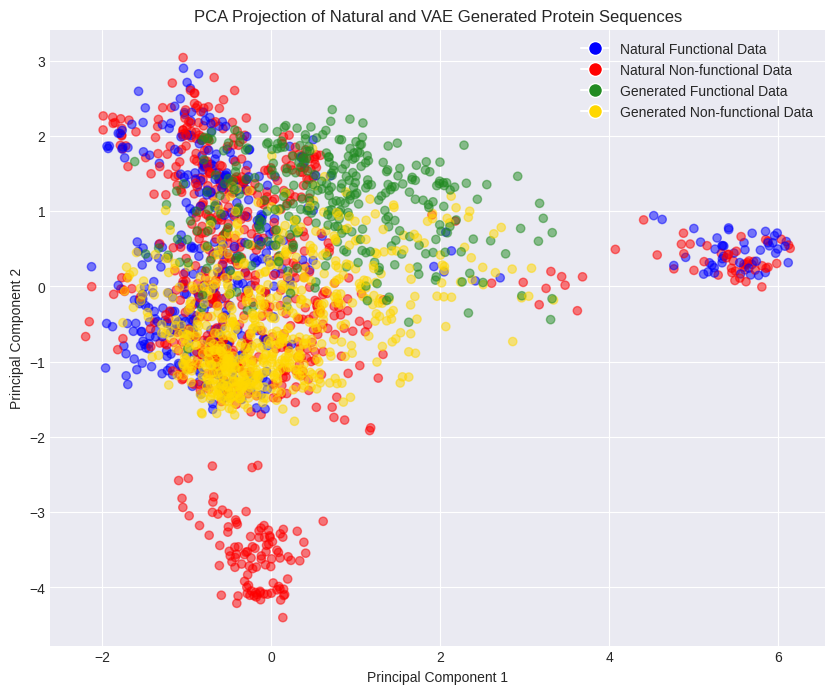

In [26]:
# Define the generated set
X_test = reshaped_gen_encoded_sequences

# Make predictions on the generated set
gen_functionality = model_c.predict(X_test)

# Color map for functionality
color_map_art = {1: 'forestgreen', 0: 'gold'}
colors_art = [color_map_art[func] for func in gen_functionality]

# Plot both natural and artificial sequences in the same PCA plot
plt.figure(figsize=(10, 8))

# Natural sequences
plt.scatter(
    principal_components_natural[:, 0],
    principal_components_natural[:, 1],
    c=colors,
    alpha=0.5,
    label='Natural'
)

# Generated sequences
plt.scatter(
    principal_components_generated[:, 0],
    principal_components_generated[:, 1],
    color=colors_art,
    alpha=0.5,
    label='Generated'
)

# Add legend for functionality and data source
legend_elements = [
    # Functionality legends
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Natural Functional Data'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Natural Non-functional Data'),
    # Data source legends
    Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=10, label='Generated Functional Data'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', markersize=10, label='Generated Non-functional Data')
]
plt.legend(handles=legend_elements, loc='best')

# Add title and labels
plt.title('PCA Projection of Natural and VAE Generated Protein Sequences')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()